# Modeling

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from catboost import CatBoostRegressor
import shap


from sklearn.preprocessing import MinMaxScaler

## Prepare the Data Sets
We want to create two separate datasets; one for our CatBoost model and one for our Keras models.

In [69]:
df = pd.read_parquet("../data/structured/general/combined_data.parquet")
df = df.dropna()

In [70]:
df = df[[c for c in list(df) if "_adj" not in c]]
df

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile,days_since_start,is_starting,Netto Power,Power / vane opening,seconds_since_last_data,seconds_since_last_start,Power / Drafttube pressure
timepoints,,,,,,,,,,,,,,,,,,,
1970-12-19 09:51:45,262.104319,3.344630,82.277248,173.989815,5311.219755,107.964273,1598.477449,1480.989528,1684.261611,1601.366508,1635.588478,1674.823883,0.0,0,258.759689,3.185623,1.0,1.0,1.506435
1970-12-19 09:51:46,262.004330,3.790223,82.274520,174.024413,5311.640329,107.964269,1598.479316,1481.003188,1684.270504,1601.374254,1635.583464,1674.841318,0.0,0,258.214106,3.184514,1.0,2.0,1.505561
1970-12-19 09:51:47,261.904340,4.235817,82.271792,174.059012,5312.060902,107.964264,1598.490184,1481.028827,1684.270683,1601.383179,1635.581384,1674.843245,0.0,0,257.668524,3.183404,1.0,3.0,1.504687
1970-12-19 09:51:48,261.804351,4.064759,82.269064,174.153819,5312.405938,107.964259,1598.494073,1481.059017,1684.271062,1601.378391,1635.591746,1674.872300,0.0,0,257.739592,3.182294,1.0,4.0,1.503294
1970-12-19 09:51:49,261.704362,3.170510,82.266336,174.422046,5312.533396,107.964254,1598.498916,1481.075521,1684.276622,1601.380601,1635.607884,1674.924469,0.0,0,258.533851,3.181184,1.0,5.0,1.500409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971-01-25 11:06:44,308.716025,3.974309,94.425666,157.927905,5280.929965,108.057498,1637.386115,1504.557822,1701.651420,1606.276545,1640.704071,1690.014705,5.0,0,304.741716,3.269408,1.0,19788.0,1.954791
1971-01-25 11:06:45,308.746393,4.103262,94.429003,157.974925,5280.633358,108.057492,1637.365865,1504.546091,1701.654301,1606.271877,1640.711250,1690.017029,5.0,0,304.643131,3.269614,1.0,19789.0,1.954401
1971-01-25 11:06:46,308.776762,4.472929,94.432340,158.021945,5280.336751,108.057486,1637.384133,1504.538696,1701.656143,1606.250028,1640.699142,1690.002008,5.0,0,304.303833,3.269820,1.0,19790.0,1.954012


In [71]:
X_cols = ["Unit_4_Power", "Unit_4_Reactive Power", "Turbine_Guide Vane Opening", "Turbine_Pressure Drafttube", "Turbine_Pressure Spiral Casing", "Turbine_Rotational Speed"]
y_cols = [c for c in df if c.endswith("Tensile")]

### Create CatBoost dataset

In [74]:
X_cols = ["Unit_4_Power", "Unit_4_Reactive Power", "Turbine_Guide Vane Opening", "Turbine_Pressure Drafttube", "Turbine_Pressure Spiral Casing", "Turbine_Rotational Speed"]
extra_cols = ["days_since_start"]

In [75]:
lookback = 20

iterate_cols = list(df.drop(columns=extra_cols+y_cols).columns)

cX = df.drop(columns=y_cols).copy()
for i in range(1, lookback+1):
    cX.loc[:, [f"{c} (t-{i})" for c in iterate_cols]] = cX[iterate_cols].shift(i).rename(columns={c: f"{c} (t-{i})" for c in iterate_cols})

cX = cX[[c for c in cX if c not in X_cols]]
cy = df[y_cols]

cX

,days_since_start,is_starting,Netto Power,Power / vane opening,seconds_since_last_data,seconds_since_last_start,Power / Drafttube pressure,Unit_4_Power (t-1),Unit_4_Reactive Power (t-1),Turbine_Guide Vane Opening (t-1),...,Turbine_Guide Vane Opening (t-20),Turbine_Pressure Drafttube (t-20),Turbine_Pressure Spiral Casing (t-20),Turbine_Rotational Speed (t-20),is_starting (t-20),Netto Power (t-20),Power / vane opening (t-20),seconds_since_last_data (t-20),seconds_since_last_start (t-20),Power / Drafttube pressure (t-20)
timepoints,,,,,,,,,,,,,,,,,,,,,
1970-12-19 09:51:45,0.0,0,258.759689,3.185623,1.0,1.0,1.506435,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-12-19 09:51:46,0.0,0,258.214106,3.184514,1.0,2.0,1.505561,262.104319,3.344630,82.277248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-12-19 09:51:47,0.0,0,257.668524,3.183404,1.0,3.0,1.504687,262.004330,3.790223,82.274520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-12-19 09:51:48,0.0,0,257.739592,3.182294,1.0,4.0,1.503294,261.904340,4.235817,82.271792,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-12-19 09:51:49,0.0,0,258.533851,3.181184,1.0,5.0,1.500409,261.804351,4.064759,82.269064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971-01-25 11:06:44,5.0,0,304.741716,3.269408,1.0,19788.0,1.954791,308.685656,4.382225,94.422329,...,94.358928,158.501036,5282.203114,108.057625,0.0,303.796817,3.265284,1.0,19768.0,1.943890
1971-01-25 11:06:45,5.0,0,304.643131,3.269614,1.0,19789.0,1.954401,308.716025,3.974309,94.425666,...,94.362264,158.728007,5282.350036,108.057619,0.0,303.830018,3.265490,1.0,19769.0,1.941302
1971-01-25 11:06:46,5.0,0,304.303833,3.269820,1.0,19790.0,1.954012,308.746393,4.103262,94.429003,...,94.365601,158.954979,5282.496959,108.057612,0.0,303.812089,3.265696,1.0,19770.0,1.938721


In [76]:
def train_test_split(X, y, test_percent=0.1, offset_percent=0):
    
    test_start = int(len(df) * offset_percent)
    test_end = int(len(df) * (offset_percent + test_percent))

    X_train, X_test = X.iloc[:test_start], X.iloc[test_start:test_end]
    y_train, y_test = y.iloc[:test_start], y.iloc[test_start:test_end]
    
    return X_train, X_test, y_train, y_test

cX_train, cX_test, cy_train, cy_test = train_test_split(cX, cy, test_percent=0.1, offset_percent=0.9)

### CatBoost Modeling

In [77]:
params = {
    "loss_function": "MAPE",
    "iterations": 100,
    "depth": 5
}

cy_trains = [cy_train[c] for c in cy_train]
cy_tests = [cy_test[c] for c in cy_test]

models = []

for j in range(len(cy_trains)):
    model = CatBoostRegressor(**params)
    model.fit(cX_train, cy_trains[j], eval_set=(cX_test, cy_tests[j]), verbose=False)
    models.append(model)

In [78]:
model = models[0]

In [79]:
explainer = shap.Explainer(model)
shap_values = explainer(cX_train)

In [80]:
sdf = pd.DataFrame(shap_values.values, columns=cX_train.columns).abs().sum()

In [81]:
sdf_ = pd.Series(sdf.index, index=sdf.index).apply(lambda s: s[:s.index("(")-1] if "(" in s else s)
sdf = sdf.groupby(sdf_).sum().sort_values()
sdf


Power / vane opening              0.000000e+00
seconds_since_last_data           0.000000e+00
is_starting                       3.301339e+03
Power / Drafttube pressure        3.772779e+04
Unit_4_Reactive Power             5.431032e+04
Unit_4_Power                      1.230199e+05
Turbine_Rotational Speed          3.690764e+05
Turbine_Guide Vane Opening        6.031478e+05
Netto Power                       8.116498e+05
Turbine_Pressure Spiral Casing    9.285420e+05
seconds_since_last_start          1.409518e+06
Turbine_Pressure Drafttube        1.930313e+06
days_since_start                  7.802945e+06
dtype: float64

In [82]:
#sdf[[c for c in sdf.index if "Reactive Power" in c]].sort_values()

In [83]:
shap.plots.beeswarm(shap_values, max_display=250, order=shap_values.abs.mean(0))

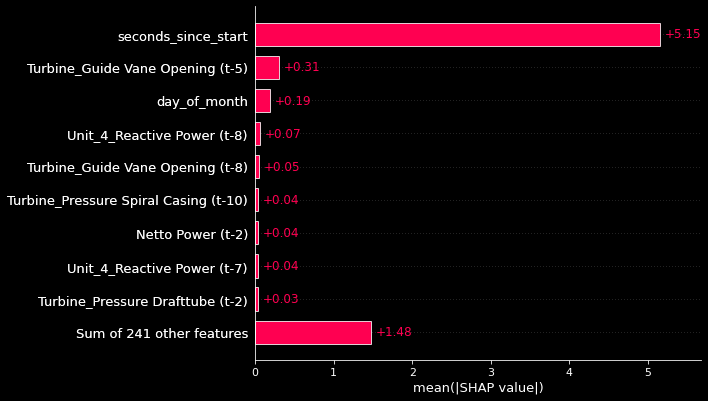

In [ ]:
shap.plots.bar(shap_values.abs.mean(0))